# Set up

In [1]:
import pandas as pd
from tqdm.auto import tqdm

from util_functions import (
    retrieve_uniprot_data_by_acess,
    get_domain,
    rename_for_lab,
    save_df_to_fasta,
    read_blast,
    align,
    print_heatmap,
    get_pictures,
    get_genes_for_point_aln
)

# Get acess id for known Ly6/uPAR genes

In [2]:
uniprot = pd.read_csv('seqs/csv/uniprot-filtered-reviewed_yes.tab', sep='\t', index_col=0).drop_duplicates('Sequence')
uniprot = uniprot[~uniprot['Domain [FT]'].isna()].copy()
uniprot = uniprot[uniprot['Domain [FT]'].str.lower().str.contains('upar')].copy()
uniprot.head()

,Entry name,Protein names,Gene names,Organism,Length,Domain [FT],Sequence
Entry,,,,,,,
P0DP61,SLUR2_MACMU,Secreted Ly-6/uPAR domain-containing protein 2,SLURP2,Macaca mulatta (Rhesus macaque),97,"DOMAIN 23..95; /note=""UPAR/Ly6""",MQFHTGLLLAAVLSLQLAAAQALWCHQCTGFGGCSRGSRCPRDSTH...
P55000,SLUR1_HUMAN,Secreted Ly-6/uPAR-related protein 1 (SLURP-1)...,SLURP1 ARS,Homo sapiens (Human),103,"DOMAIN 24..73; /note=""UPAR/Ly6""",MASRWAVQLLLVAAWSMGCGEALKCYTCKEPMTSASCRTITRCKPE...
P83107,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1 (Protein BOP1),SOLD1 BOP1,Bos taurus (Bovine),100,"DOMAIN 23..100; /note=""UPAR/Ly6""; /evidence=...",MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...
P0DP57,SLUR2_HUMAN,Secreted Ly-6/uPAR domain-containing protein 2...,SLURP2,Homo sapiens (Human),97,"DOMAIN 25..95; /note=""UPAR/Ly6""; /evidence=""...",MQLGTGLLLAAVLSLQLAAAEAIWCHQCTGFGGCSHGSRCLRDSTH...
D3YWX3,PAT13_MOUSE,Prostate and testis expressed protein 13 (Pros...,Pate13 Gm3867 Pate-X,Mus musculus (Mouse),137,"DOMAIN 28..114; /note=""UPAR/Ly6""; /evidence=...",MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...


In [3]:
known_upars = set(uniprot.index) | set(pd.read_csv('seqs/csv/acess_upar.txt', squeeze=True))
len(known_upars)

198

# Retrieve all known Ly6/uPAR genes from uniprot by acess

In [4]:
res = pd.DataFrame()
for acess in tqdm(known_upars):
    tmp = retrieve_uniprot_data_by_acess(acess)
    if tmp:
        res = res.append(tmp, ignore_index=True)
    else:
        print('!!!!!!!!!!!!!!!')
        break
res = res.drop_duplicates('sequence')

# Get long and short Ly6/uPARs to different DFs
short = res[res.sequence.str.len() < 190].copy()
short = short.fillna(-1)
short.start, short.end = short.start.astype(int), short.end.astype(int)

long = res[res.sequence.str.len() > 190].copy()

  0%|          | 0/198 [00:00<?, ?it/s]

In [5]:
res.shape[0] == res.drop_duplicates('id').shape[0]

True

In [6]:
print(long.shape, short.shape)
res.head()

(44, 8) (153, 8)


,sequence,id,protein_name,org,start,end,type_,acess
0,MDTSHTTKSCVLILLVALLCAERAQGLQCYECYGVPIETSCPAVTC...,LY6C1_MOUSE,Lymphocyte antigen 6C1,Mus musculus,27,115,DOMAIN,P0CW02
1,RICYNHLGTKPPTTETCQEDSCYKNIWTFDNIIRRGCGCFTPRGDM...,3SPM_DENJA,Dendroaspin,Dendroaspis jamesoni kaimosae,1,59,CHAIN,P28375
2,MLVLFLLGTVFLLCPYWGELHDPIKATEIMCYECKKYHLGLCYGVM...,PATE2_HUMAN,Prostate and testis expressed protein 2,Homo sapiens,29,110,DOMAIN,Q6UY27
3,MLLFALLLAMELPLVAASATMRAQWTYSLRCHDCAVINDFNCPNIR...,GML_HUMAN,Glycosyl-phosphatidylinositol-anchored molecul...,Homo sapiens,29,134,DOMAIN,Q99445
4,MRALLLLSLSALLCWVSADIRCHSCYKLPVLGCVDRKSCRLEPGQQ...,LY66C_BOVIN,Lymphocyte antigen 6 complex locus protein G6c,Bos taurus,20,111,DOMAIN,A0JNL5


# Retrieve LU-domains from protein sequences

In [7]:
short['domain'] = short.apply(get_domain, axis=1)
short = short.drop_duplicates('sequence')
inds = short[short.domain.isna()].index
print(inds)
for i in inds:
    short.loc[i, 'domain'] = short.loc[i, 'sequence'][short.loc[i, 'start']: short.loc[i, 'end']]
short.head()

Int64Index([123], dtype='int64')


,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MDTSHTTKSCVLILLVALLCAERAQGLQCYECYGVPIETSCPAVTC...,LY6C1_MOUSE,Lymphocyte antigen 6C1,Mus musculus,27,115,DOMAIN,P0CW02,LQCYECYGVPIETSCPAVTCRASDGFCIAQNIELIEDSQRRKLKTR...
1,RICYNHLGTKPPTTETCQEDSCYKNIWTFDNIIRRGCGCFTPRGDM...,3SPM_DENJA,Dendroaspin,Dendroaspis jamesoni kaimosae,1,59,CHAIN,P28375,RICYNHLGTKPPTTETCQEDSCYKNIWTFDNIIRRGCGCFTPRGDM...
2,MLVLFLLGTVFLLCPYWGELHDPIKATEIMCYECKKYHLGLCYGVM...,PATE2_HUMAN,Prostate and testis expressed protein 2,Homo sapiens,29,110,DOMAIN,Q6UY27,IMCYECKKYHLGLCYGVMTSCSLKHKQSCAVENFYILTRKGQSMYH...
3,MLLFALLLAMELPLVAASATMRAQWTYSLRCHDCAVINDFNCPNIR...,GML_HUMAN,Glycosyl-phosphatidylinositol-anchored molecul...,Homo sapiens,29,134,DOMAIN,Q99445,HDCAVINDFNCPNIRVCPYHIRRCMTISIRINSRELLVYKNCTNNC...
4,MRALLLLSLSALLCWVSADIRCHSCYKLPVLGCVDRKSCRLEPGQQ...,LY66C_BOVIN,Lymphocyte antigen 6 complex locus protein G6c,Bos taurus,20,111,DOMAIN,A0JNL5,IRCHSCYKLPVLGCVDRKSCRLEPGQQCLTTHAYIGKMWVFSRLDC...


# Rename some ids

In [8]:
short = short.apply(rename_for_lab, axis=1)
short.id = short.id.str.rsplit('_', 1).str[0] + '_|_' + short.org.str.replace(' ', '_')
short.to_csv('seqs/csv/short_upar_all_data.csv', index=None)
short.head()

,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MDTSHTTKSCVLILLVALLCAERAQGLQCYECYGVPIETSCPAVTC...,LY6C1_|_Mus_musculus,Lymphocyte antigen 6C1,Mus musculus,27,115,DOMAIN,P0CW02,LQCYECYGVPIETSCPAVTCRASDGFCIAQNIELIEDSQRRKLKTR...
1,RICYNHLGTKPPTTETCQEDSCYKNIWTFDNIIRRGCGCFTPRGDM...,DENDROASPIN_|_Dendroaspis_jamesoni_kaimosae,Dendroaspin,Dendroaspis jamesoni kaimosae,1,59,CHAIN,P28375,RICYNHLGTKPPTTETCQEDSCYKNIWTFDNIIRRGCGCFTPRGDM...
2,MLVLFLLGTVFLLCPYWGELHDPIKATEIMCYECKKYHLGLCYGVM...,PATE2_|_Homo_sapiens,Prostate and testis expressed protein 2,Homo sapiens,29,110,DOMAIN,Q6UY27,IMCYECKKYHLGLCYGVMTSCSLKHKQSCAVENFYILTRKGQSMYH...
3,MLLFALLLAMELPLVAASATMRAQWTYSLRCHDCAVINDFNCPNIR...,GML_|_Homo_sapiens,Glycosyl-phosphatidylinositol-anchored molecul...,Homo sapiens,29,134,DOMAIN,Q99445,HDCAVINDFNCPNIRVCPYHIRRCMTISIRINSRELLVYKNCTNNC...
4,MRALLLLSLSALLCWVSADIRCHSCYKLPVLGCVDRKSCRLEPGQQ...,LY66C_|_Bos_taurus,Lymphocyte antigen 6 complex locus protein G6c,Bos taurus,20,111,DOMAIN,A0JNL5,IRCHSCYKLPVLGCVDRKSCRLEPGQQCLTTHAYIGKMWVFSRLDC...


In [9]:
# Save preprocessed data
short = pd.read_csv('seqs/csv/short_upar_all_data.csv')

# Blast

In [10]:
save_df_to_fasta(short, 'blast/blastdb/short_ly_domain_db.fs', seq_col='domain')

In [11]:
%%bash -s 'short_ly_domain_db.fs'
cd 'blast/blastdb/'
makeblastdb -in "$1" -dbtype prot



Building a new DB, current time: 11/27/2021 16:05:09
New DB name:   /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
New DB title:  short_ly_domain_db.fs
Sequence type: Protein
Deleted existing Protein BLAST database named /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 153 sequences in 0.00360394 seconds.


In [12]:
%%bash -s 'blastdb/short_ly_domain_db.fs' 'aplanci_blast_short.txt' 'arubens_blast_short.txt'
cd 'blast'
blastp -db "$1" -query "../seqs/aplanci_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$2"
blastp -db "$1" -query "../seqs/arubens_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$3"
ls

aplanci_blast_short.txt
arubens_blast_short.txt
blastdb


In [13]:
aru = read_blast('arubens_seq.csv', 'Asterias rubens')
apl = read_blast('aplanci_seq.csv', 'Acanthaster planci')
print(aru.shape[0], apl.shape[0])

5 7


In [14]:
aru

,sequence,gene_len,org,domain
genes,,,,
XP_033628517.1_|_Asterias_rubens,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,Asterias rubens,LQCFTCEAEDTNENCNIKEAPVLKTCTSRQDRCLTQVIYSTERGKL...
XP_033635706.1_|_Asterias_rubens,MLMSNQHQCSMYSLRLLLLVVAIMYDATLVMGQTACSVADPVCRCT...,1123,Asterias rubens,AQCYTPESVQRQTIREAPFCIPVQRCYFCDQASTNGACNFATQLCS...
XP_033638913.1_|_Asterias_rubens,MNTLATIVVLMSLIAGMSALTCNTCGWITGVSDESCLDEFDATASN...,126,Asterias rubens,LTCNTCGWITGVSDESCLDEFDATASNSSVTCASGYDMCSKSTTKV...
XP_033640057.1_|_Asterias_rubens,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,Asterias rubens,IKCFTCTDKKSNRECNERAYDAFCPKGTKYCYSSHYLNQKSGESIL...
XP_033644501.1_|_Asterias_rubens,METNPSSQRLVVWMFIFAATIYFAQGNLRCYDCDVDFKTMSNPDLN...,152,Asterias rubens,LRCYDCDVDFKTMSNPDLNCIHNVINSTGDVMYEPRDCQPHERFCK...


In [15]:
apl

,sequence,gene_len,org,domain
genes,,,,
XP_022086630.1_|_Acanthaster_planci,MKMHPINLIFSLVGNVVGLECFDCVDGVSPALDTVACADLFNRTTT...,135,Acanthaster planci,LECFDCVDGVSPALDTVACADLFNRTTTDSRVNRRPCPAGFDACAK...
XP_022094712.1_|_Acanthaster_planci,MWCSMLDLFIASLLICIHTVYSLQCYTCAAEDTNENCKINEAPVLR...,137,Acanthaster planci,LQCYTCAAEDTNENCKINEAPVLRTCPSTEDRCLTQVIYSTERGKL...
XP_022094807.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1135,Acanthaster planci,QRCYFCDSASTNAACNFAQQQCSGINPACQNEVRVTSGRFLISKSC...
XP_022094806.1_|_Acanthaster_planci,MTTIAPTSLLFLVLLLIPRESAAVASQQPLACGDSTGAVAPLCRCT...,1235,Acanthaster planci,LVCEGGEFSISCGMGGTIDVQWALYGREDGSQACFTPRATPCGDPE...
XP_022100632.1_|_Acanthaster_planci,MKLLLIAGILLASVGSLSAAECYLCSYVPSAMGEECKDPFNSSNNS...,124,Acanthaster planci,AECYLCSYVPSAMGEECKDPFNSSNNSTETCEGTYCLKVVSKISGE...
XP_022109332.1_|_Acanthaster_planci,MHSPSAFLNDVFLQNAVKKHFVMLVCWPKVIQQWLSAAIFCLVFMS...,200,Acanthaster planci,VKCFTCIDKKSNRECNERAYDAFCPKGTKYCYSSHYVNQKTGESIL...
XP_022111363.1_|_Acanthaster_planci,MYLTLFFVNSLFKISNTAKQMDIKLRILMIVILVNNPHNGNAISCY...,344,Acanthaster planci,ISCYVCDTSSNDDCNPGTSTTCGSEQICMNEVREENGLFIVRKMCK...


# MSA

In [16]:
df = pd.concat([short.set_index('id'), apl]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_apl_short_upar.fasta', seq_col='domain')

In [17]:
df = pd.concat([short.set_index('id'), aru]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_aru_short_upar.fasta', seq_col='domain')

In [18]:
align('seqs/blast_aru_short_upar.fasta', 'result/aln/blast_aru_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











In [19]:
align('seqs/blast_apl_short_upar.fasta', 'result/aln/blast_apl_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein











# Pictures

## Get heatmaps of blast hits

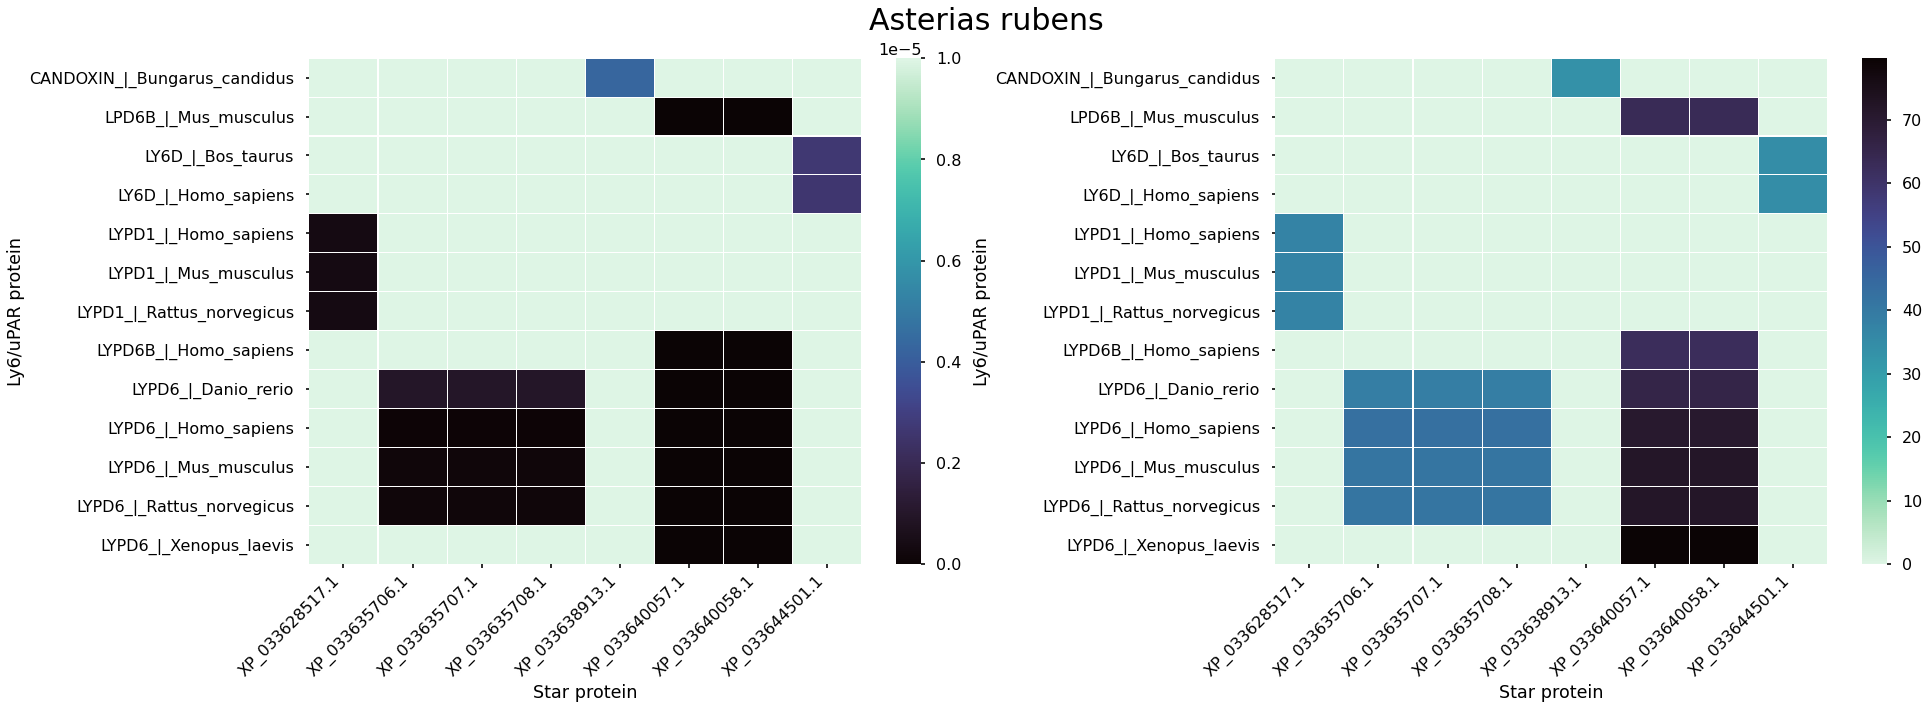

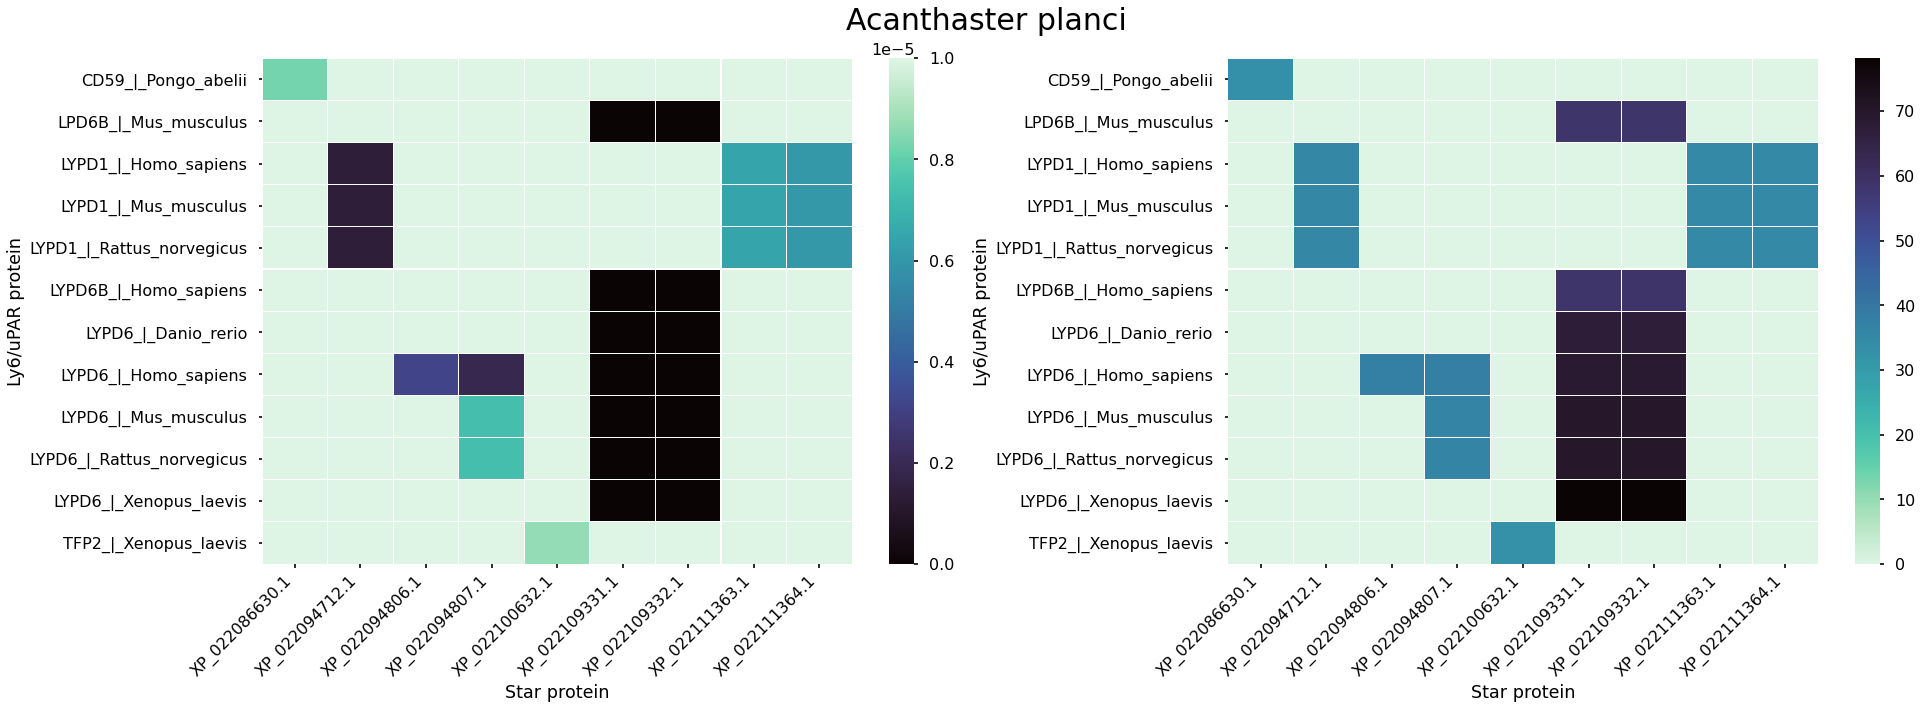

In [20]:
print_heatmap('blast/arubens_blast_short.txt', organism='Asterias rubens')
print_heatmap('blast/aplanci_blast_short.txt', organism='Acanthaster planci')

## Plot alignments

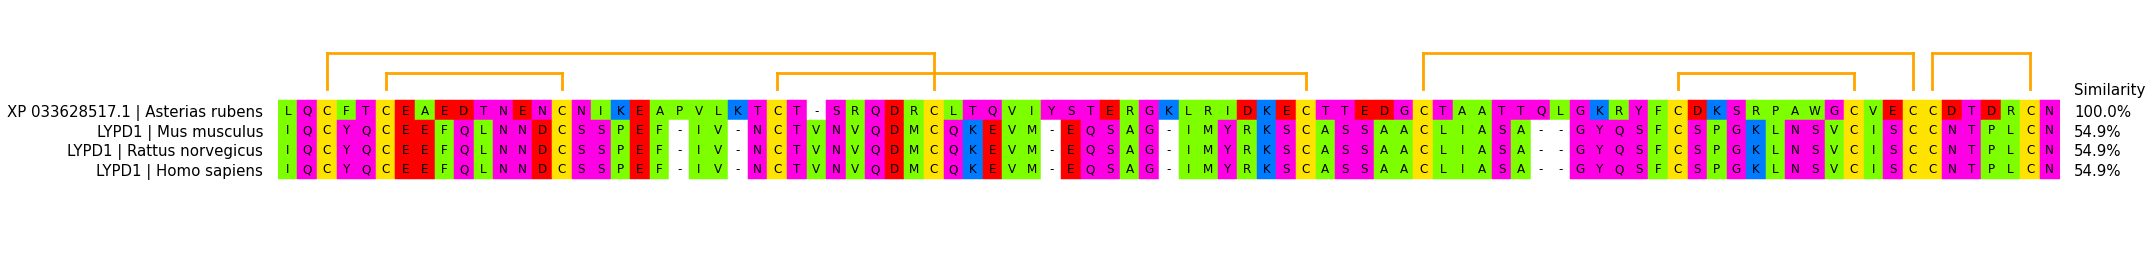

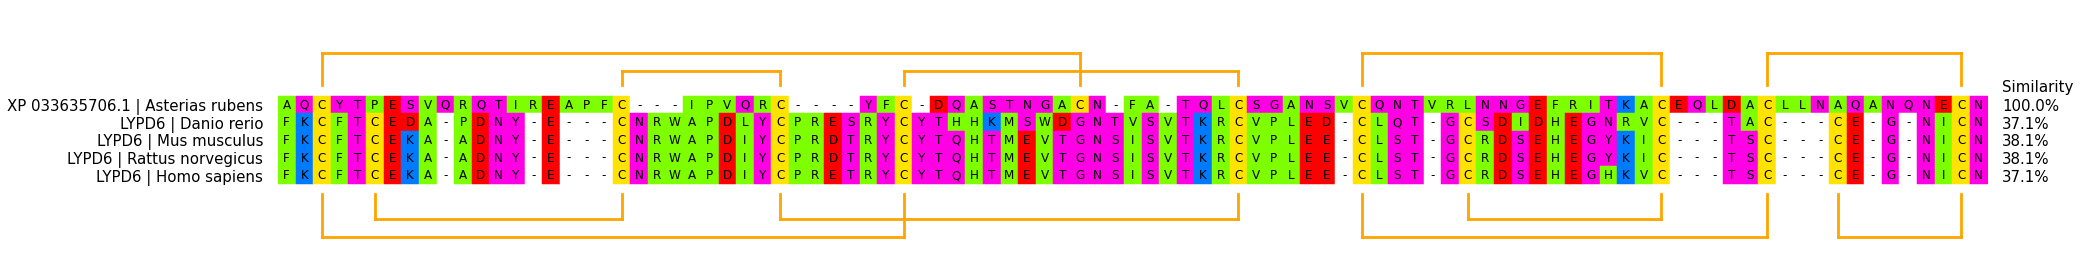

XP_033635707.1 protein has duplicated domain
 "None of [Index(['XP_033635707.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"
XP_033635708.1 protein has duplicated domain
 "None of [Index(['XP_033635708.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


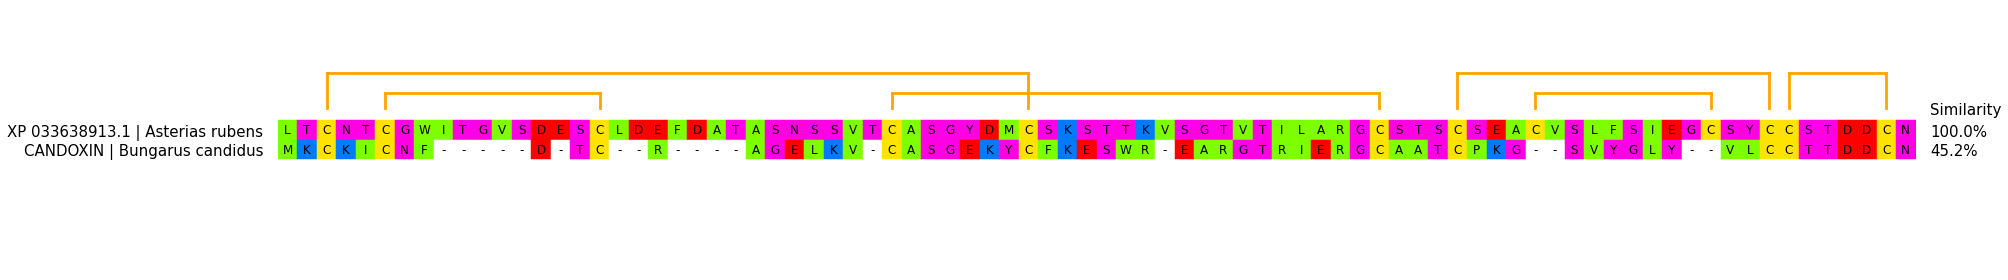

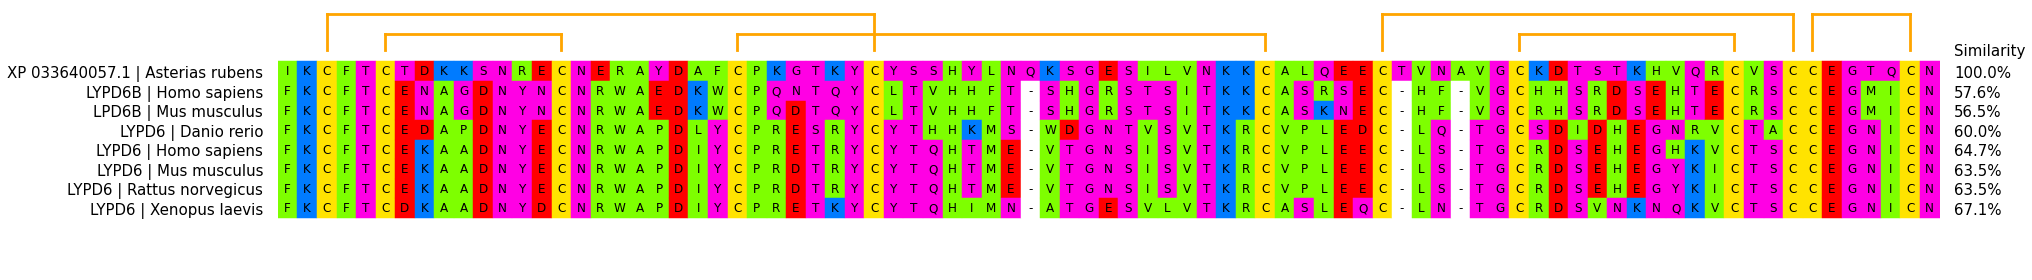

XP_033640058.1 protein has duplicated domain
 "None of [Index(['XP_033640058.1_|_Asterias_rubens'], dtype='object', name='genes')] are in the [index]"


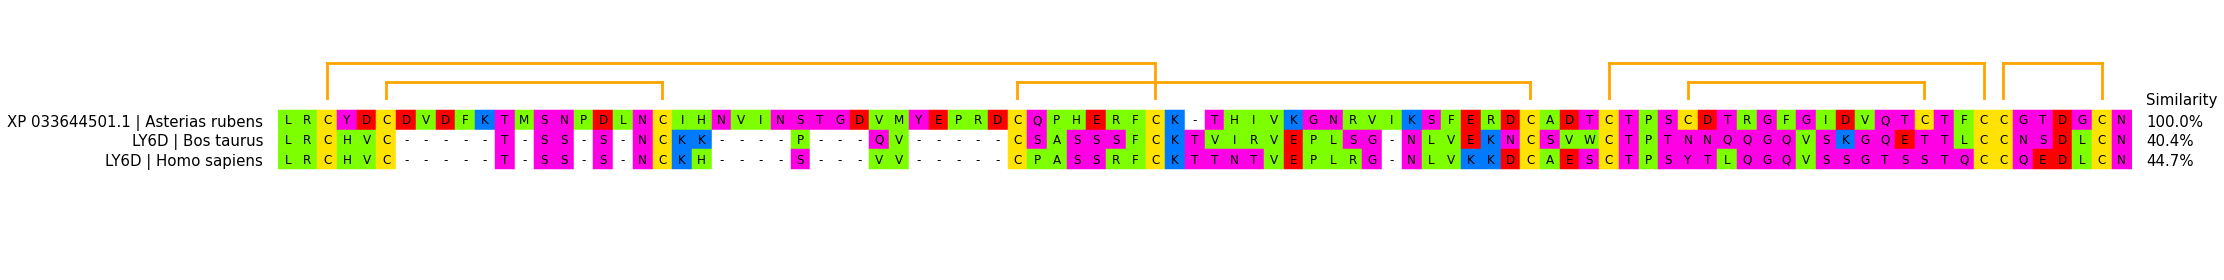

In [21]:
organism = 'Asterias rubens'
df = get_genes_for_point_aln('arubens')
get_pictures(aru, df, short, organism)

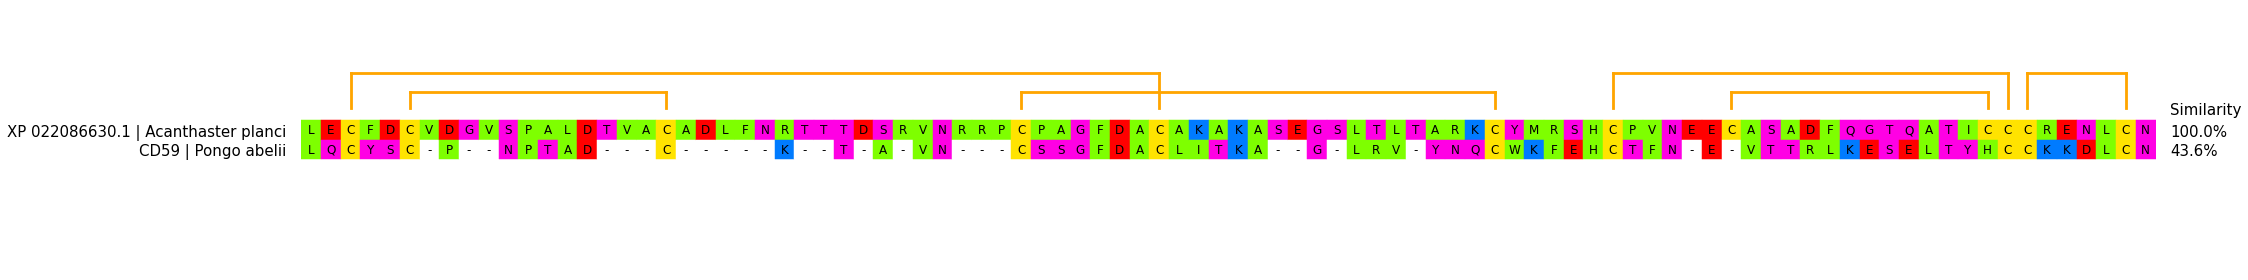

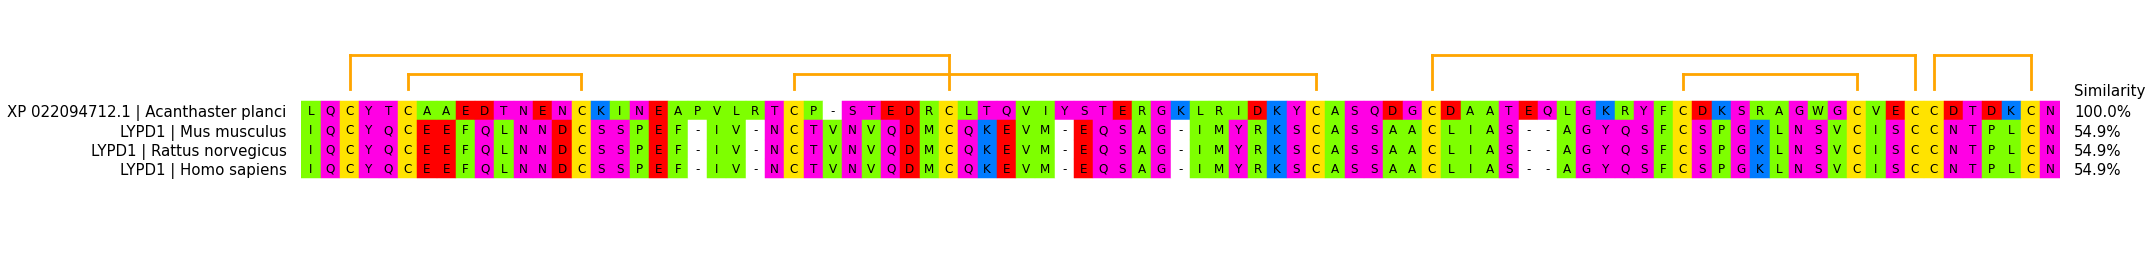

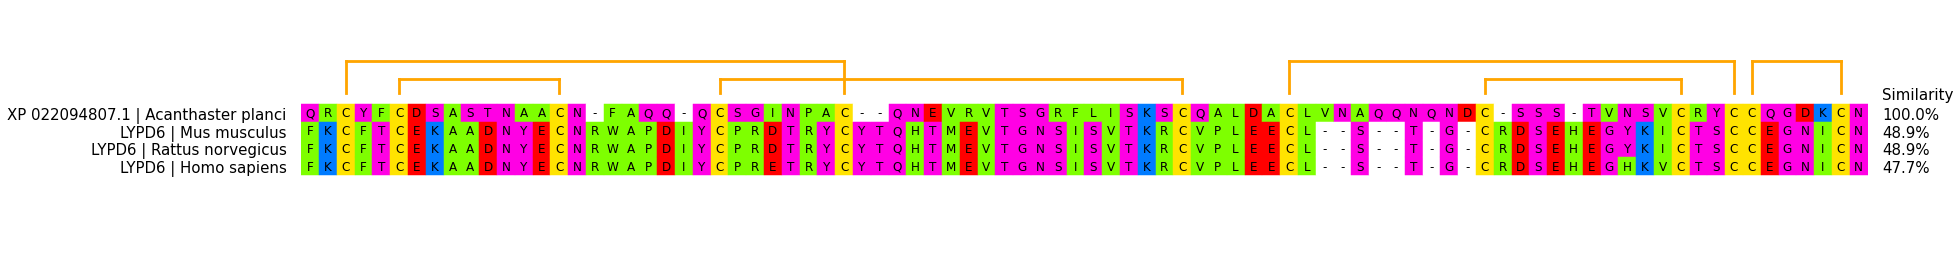

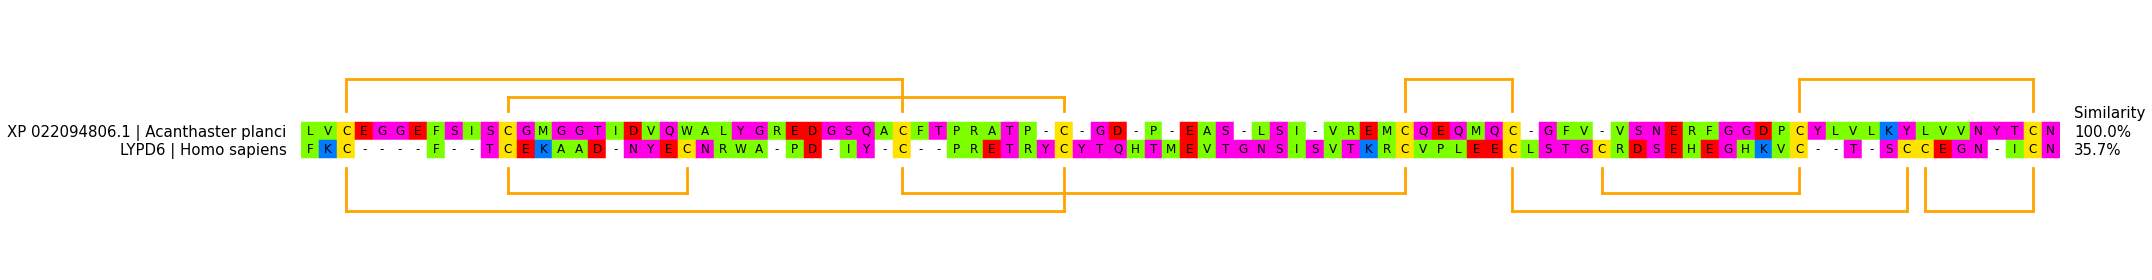

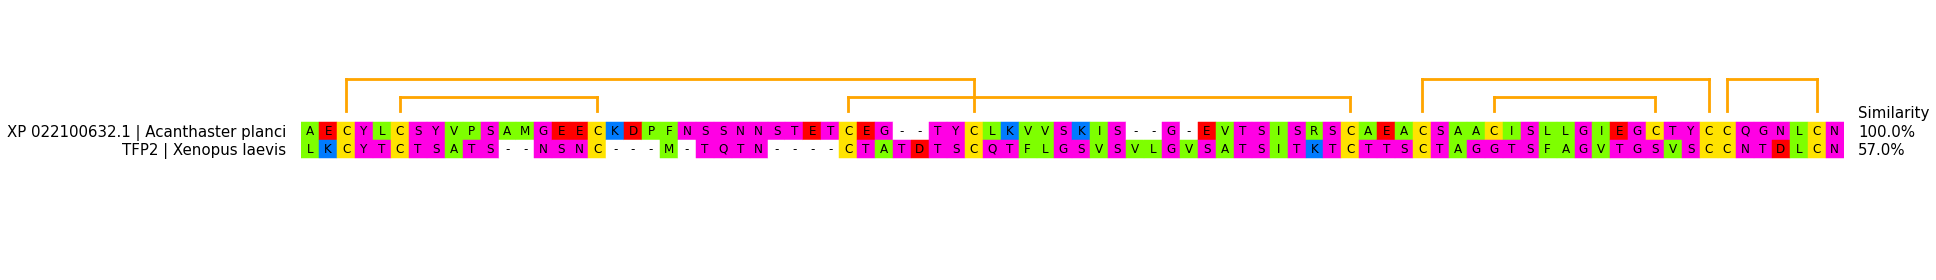

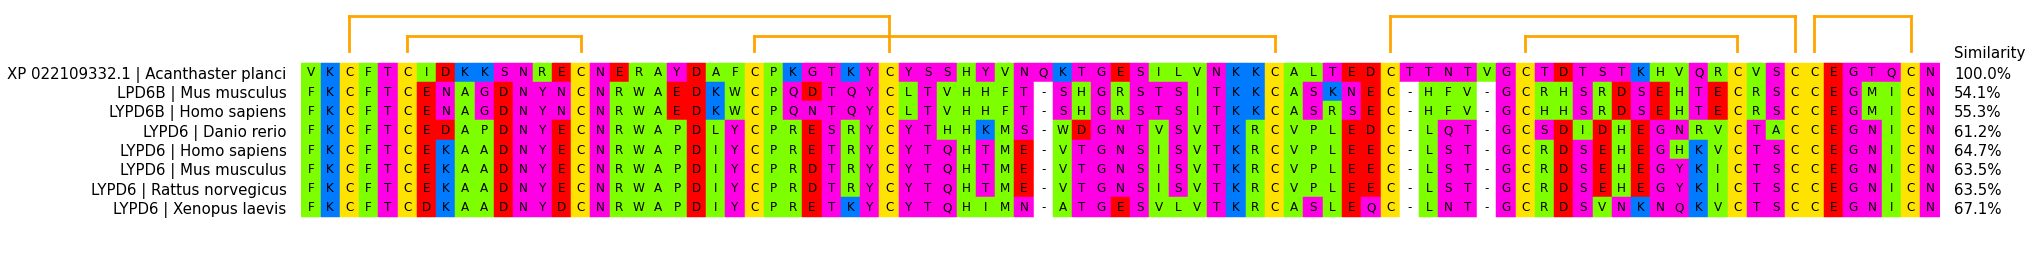

XP_022109331.1 protein has duplicated domain
 "None of [Index(['XP_022109331.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


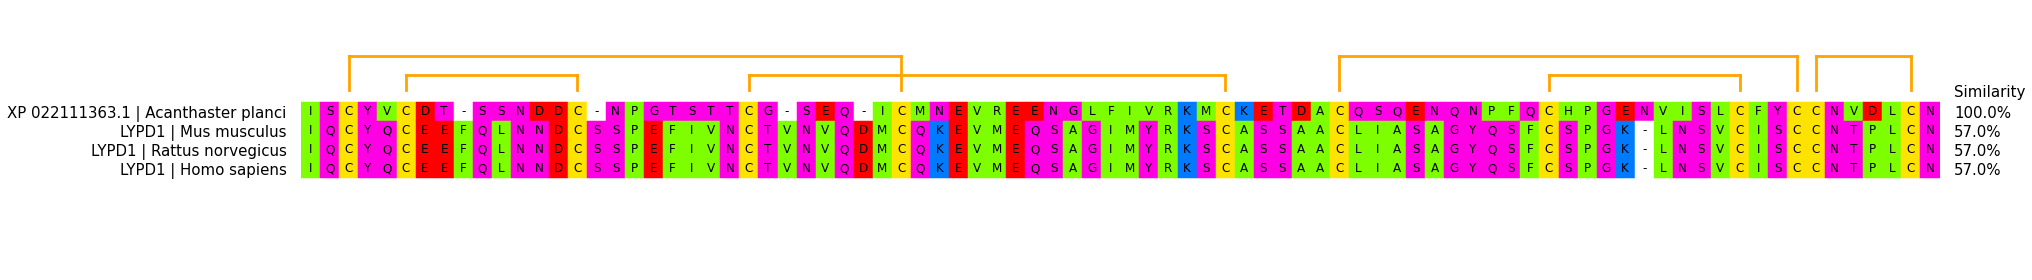

XP_022111364.1 protein has duplicated domain
 "None of [Index(['XP_022111364.1_|_Acanthaster_planci'], dtype='object', name='genes')] are in the [index]"


In [22]:
organism = 'Acanthaster planci'
df = get_genes_for_point_aln('aplanci')
get_pictures(star_blast=apl, df=df, uniprot=short, organism=organism)

# Get dataset for ITOL

In [23]:
mapper_color_itol = {
    'Amphibia': '\trange\t#e7ffac\tAmphibia\n',
    'Actinopterygii': '\trange\t#c4faf8\tActinopterygii\n',
#     'Cytotoxins': '\trange\t#b5b9ff\tCytotoxins\n',
#     'MT family': '\trange\t#ffb5e8\tMT family\n',
    'Mammalia': '\trange\t#fbe4ff\tMammalia\n',
    'Toxins': '\trange\t#fff5ba\tToxins\n',
    'Insecta': '\trange\t#cfe2f3\tInsecta\n',
    'Lystar proteins' : '\trange\t#ff4b4b\tLystar proteins\n',
#     'Fasciculins': '\trange\t#dcd3ff\tFasciculins\n',
    'Aves': '\trange\t#ffcbc1\tAves\n',
    'Parasites': '\trange\t#ffffff\tParasite of humans\n'
}

In [24]:
mapper_tax_itol = {
    'Schistosoma mansoni': 'Parasites',
    'Homo sapiens': 'Mammalia',
    'Dendroaspis angusticeps': 'Toxins',
    'Aneides lugubris': 'Amphibia',
    'Macaca mulatta': 'Mammalia',
    'Naja oxiana': 'Toxins',
    'Rattus norvegicus': 'Mammalia',
    'Naja kaouthia': 'Toxins',
    'Laticauda semifasciata': 'Toxins',
    'Danio rerio': 'Actinopterygii',
    'Oryctolagus cuniculus': 'Mammalia',
    'Sus scrofa': 'Mammalia',
    'Mus musculus': 'Mammalia',
    'Dendroaspis polylepis polylepis': 'Toxins',
    'Bos taurus': 'Mammalia',
    'Gallus gallus': 'Aves',
    'Saimiri sciureus': 'Mammalia',
    'Xenopus laevis': 'Amphibia',
    'Micrurus altirostris': 'Toxins',
    'Bungarus candidus': 'Toxins',
    'Laticauda colubrina': 'Toxins',
    'Lithobates sylvaticus': 'Amphibia',
    'Callithrix sp.': 'Mammalia',
    'Dendroaspis jamesoni kaimosae': 'Toxins',
    'Aotus trivirgatus': 'Mammalia',
    'Papio sp.': 'Mammalia',
    'Canis lupus familiaris': 'Mammalia',
    'Naja atra': 'Toxins',
    'Saimiriine herpesvirus 2 (strain 11)': 'Parasites',
    'Micrurus mipartitus': 'Toxins',
    'Saimiri boliviensis boliviensis': 'Mammalia',
    'Macaca fascicularis': 'Mammalia',
    'Batrachuperus londongensis': 'Amphibia',
    'Boiga irregularis': 'Toxins',
    'Pan troglodytes': 'Mammalia',
    'Notophthalmus viridescens': 'Amphibia',
    'Oryzias latipes': 'Actinopterygii',
    'Drosophila melanogaster': 'Insecta',
    'Cynops orientalis': 'Amphibia',
    'Bungarus multicinctus': 'Toxins',
    'Chlorocebus aethiops': 'Mammalia',
    'Nilaparvata lugens': 'Insecta',
    'Ophiophagus hannah': 'Toxins',
    'Boiga dendrophila': 'Toxins',
    'Pongo abelii': 'Mammalia',
    'Naja pallida': 'Toxins',
    'Plethodon shermani': 'Amphibia',
    'Meleagris gallopavo': 'Aves',
    'Schistosoma mansoni': 'Parasites',
    'Asterias rubens': 'Lystar proteins',
    'Acanthaster planci': 'Lystar proteins',  
}
set(short.org.unique()) - set(mapper_tax_itol), set(mapper_tax_itol) - set(short.org.unique())

(set(), {'Acanthaster planci', 'Asterias rubens', 'Naja atra'})

In [25]:
labels = [i.split('\t')[2].strip() for i in mapper_color_itol.values()]
colors = [i.split('\t')[3].strip() for i in mapper_color_itol.values()]

In [26]:
with open('result/range_colors_arubens.txt', 'w') as f:
    f.write('TREE_COLORS\nSEPARATOR TAB\n')
    f.write('LEGEND_TITLE\tAnnotation\n')
    f.write('LEGEND_COLORS\t' + '\t'.join(colors) + '\n')
    f.write('LEGEND_LABELS\t' + '\t'.join(labels) + '\n')
    f.write('DATA\n')
    for i, j in short.iterrows():
        if 'strain 11' in j.org:
            continue
        f.write(j.id + mapper_color_itol[mapper_tax_itol.get(j.org)])
    for i, j in aru.iterrows():
        f.write(i + mapper_color_itol[mapper_tax_itol.get(j.org)])

In [27]:
with open('result/range_colors_aplanci.txt', 'w') as f:
    f.write('TREE_COLORS\nSEPARATOR TAB\n')
    f.write('LEGEND_TITLE\tAnnotation\n')
    f.write('LEGEND_COLORS\t' + '\t'.join(colors) + '\n')
    f.write('LEGEND_LABELS\t' + '\t'.join(labels) + '\n')
    f.write('DATA\n')
    for i, j in short.iterrows():
        if 'strain 11' in j.org:
            continue
        f.write(j.id + mapper_color_itol[mapper_tax_itol.get(j.org)])
    for i, j in apl.iterrows():
        f.write(i + mapper_color_itol[mapper_tax_itol.get(j.org)])